# [INF41] DH Humanist Mail Archive 

##Text mining brouillon 

Ressources utiles pour le projet : 
    
* Enron mail dataset https://www.kaggle.com/stephensebastin/topic-modeling-enron-email-dataset-updated (topic modeling) et https://www.kaggle.com/jamestollefson/enron-network-analysis (réseau)

* Exploring the Music Library Association Mailing List: A TextMining Approach http://kahyunchoi.com/papers/ismir2017_xhu.pdf
        
* Latent Dirichlet Allocation https://radimrehurek.com/gensim/models/ldamodel.html   
    
* Topic Modeling Genre: An Exploration of French Classical and Enlightenment Drama (Topic modeling mais avec MALLET en java) http://www.digitalhumanities.org/dhq/vol/11/2/000291/000291.html 
    
* http://voyant.tools.huma-num.fr/
    
* David Blei et une de ces publications introductives : Probabilistic Topic Models, Communications of the ACM, Volume 55 Issue 4, pp. 77-84, 2012.

* Cours de Julien Velcin sur la fouille de texte  et http://mediamining.univ-lyon2.fr/velcin/public/TM/introduction.pdf & http://mediamining.univ-lyon2.fr/velcin/public/HN/intro_fouilledetextes.pdf
    

A des fins de test, ce brouillon utilise l'archive humanist.2007-2008.txt' (Converted Text bien plus lisible) dispo ici http://dhhumanist.org/Archives/Converted_Text/ 
(étude en généralisation à prévoir)    
    

In [62]:
# setup des bibliothèques nécessaires en vrac dsl
#manipulation des données regex etc...
import pandas as pd
import os, sys, email,re
import os.path
from optparse import OptionParser
import numpy as np

# Plotting et visualisation 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set_style('whitegrid')
# fail to import wordcloud ???

#nlp et corpus
import gensim
from gensim import corpora
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string
from nltk.stem.porter import PorterStemmer
from nltk.tokenize.regexp import RegexpTokenizer
from subprocess import check_output

# algos : clustering TF-IDF, LDA et PCa
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA
from sklearn.decomposition import LatentDirichletAllocation
# études en réseau 
import networkx as nx




In [96]:
#chargement des données brutes nomenclature des variables h=humanist ct=convertedtext 0708=années
with open("C://Users//henry//AnacondaProjects//humanist//humanist.2007-2008.txt", 'r', encoding='ANSI') as hct0708:
    hct0708 = [line.strip() for line in hct0708.readlines()]
vectorizer = CountVectorizer( encoding='utf-8', max_df=1, stop_words='english')
vectorizer.fit(hct0708)
#liste des features 
vocab = vectorizer.get_feature_names()
#vocabulaire vectorisé
vv = vectorizer.vocabulary_

#mis en commentaire pour plus de lisibilité
#type(vv)
#len(vv)
#print(vv)

Utilisation de regex pour récupérer des éléments du corpus

In [63]:
# récupération des adresses mails dans le corpus avec une re
for line in hct0708 :
    if re.findall(r'[\w\.-]+@[\w\.-]+(\.[\w]+)+',line):
        # commenté pour alléger le notebook
     #   print(line)

SyntaxError: unexpected EOF while parsing (<ipython-input-63-bfc4013766bc>, line 6)

In [108]:
with open("C://Users//henry//AnacondaProjects//humanist//humanist.2007-2008.txt", 'r', encoding='ANSI') as hct0708:
    hct0708 = [line.strip() for line in hct0708.readlines()]
for line in hct0708 :
    if re.search(r'Subject:\s+(.*)',line):
    #commenté pour alléger le notebook
    #print(line)
#    Il est possble d'utiliser une regex similaire pour les en-tetes suivants 
#re.search(r'From:\s+(.*)',line):
#Subject: Humanist's 20th
#Date: 
#X-Humanist: 

SyntaxError: unexpected EOF while parsing (<ipython-input-108-105f873d84ec>, line 11)

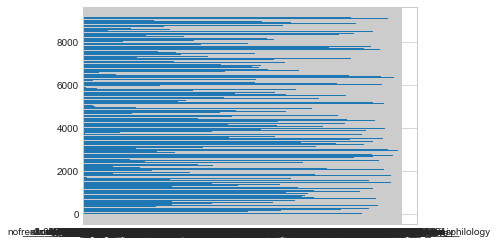

In [42]:
#peu pertinant de dessiner le plot du vocabulaire à ce stade là 
D = vv
plt.barh(range(len(D)), D.values(), align='center')
plt.xticks(range(len(D)), list(D.keys()))

plt.show()

In [83]:
lines_bag_of_words = vectorizer.transform(hct0708).toarray()
lines_bag_of_words.shape


(0, 9180)

In [111]:
tfidf_vectorizer = TfidfVectorizer(lowercase=False, stop_words='english' )
tfidf_vectorizer.fit(hct0708)
# commenté pour alléger le notebook
#tfidf_vectorizer.vocabulary_ 




TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [113]:
def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=25):
  #  ''' Return the top n features that on average are most important amongst documents in rows
#     indentified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()
    ''' D[D < min_tfidf] = 0 '''
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

top_mean_feats(X_hct0708, features_hct0708)

NameError: name 'top_tfidf_feats' is not defined

En complément de Count vectorizer, utilisation de TfidfVectorizer. TFxIDF (term frequency-inverse document frequency) permet d’évaluer l’importance des mots dans ce corpus. (plus le mot sera fréquent, plus son poids sera élevé).

In [ ]:
#Affichage des mots les plus fréquents (selon TFxIDF) :
X_hct0708 = tfidf_vectorizer.transform(hct0708)
features_hct0708 = tfidf_vectorizer.get_feature_names()

D_tf = X_hct0708.toarray()
tf_sum = np.sum(D_tf, axis=0)
top_tfidf_feats(tf_sum, features_hct0708)

Utilisation du formalisme sac de mots pour déterminer la forme du corpus. On peut maintenant construire la matrice documents * termes : à l’aide de ce sac. Ne disposant pas de catégories nous ne pouvons pas appliquer d’apprentissage supervisé Pour déterminer quel algorithme appliquer, j’ai fait appel à cette carte.http://scikit-learn.org/stable/tutorial/machine_learning_map/index.html Pour ce type de données, le clustering semble plus indiqué : cela va permettre d’utiliser la distance euclidienne pour grouper les mots les plus proches les uns des autres dans notre corpus.

In [128]:
clustering = KMeans(n_clusters=8, init='k-means++', max_iter=1000, n_init=1)
clustering.fit(X_hct0708)
#nous souhaitons affichcher les clusters avec les termes les plus proches les uns des autres dans les titres
print("Termes les plus fréquents par clusters")
centroides = clustering.cluster_centers_.argsort()[:, ::-1]
termes = features_hct0708
for i in range(8):
    print("Cluster %d:" % i),
    for ind in centroides[i, :10]:
        print(' %s' % termes[ind]),
    print

Termes les plus fréquents par clusters
Cluster 0:
 http
 www
 href
 org
 uk
 ac
 edu
 com
 html
 kcl
Cluster 1:
 Vol
 Num
 Humanist
 21
 22
 429
 261
 No
 45
 Brook
Cluster 2:
 Computing
 Humanities
 Willard
 McCarty
 London
 King
 College
 Centre
 mccarty_at_kcl
 willard
Cluster 3:
 development
 support
 services
 software
 research
 technical
 digital
 The
 projects
 use
Cluster 4:
 following
 topics
 areas
 message
 The
 include
 range
 research
 invited
 sections
Cluster 5:
 new
 work
 data
 researchers
 media
 The
 digital
 research
 humanities
 field
Cluster 6:
 The
 University
 Subject
 2008
 From
 research
 Digital
 2007
 information
 conference
Cluster 7:
 Date
 2007
 0100
 06
 0000
 Wed
 Tue
 08
 07
 09


# Conclusion 
* les regex pourront nous servir pour extraire les informations liées aux sujets, expéditeurs des mails ou àccéder à des chaines de caractères si besoin. 
* les analyse par _Vector Space model_ et le clustering par Kmeans sont inexploitables  : le besoin de stopwords personnalisés se fait sentir. 
* pour la suite  Modèle probabiliste avec Allocation de Dirichlet Latente  plus adaptée ? [en cours] 


In [133]:
#tentative de LDA .... 
#id2word = gensim.corpora.Dictionary.load_from_text(hct0708)
#lda = gensim.models.ldamodel.LdaModel(corpus=X_hct0708, id2word=id2word, num_topics=10, update_every=0, passes=200)
